In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [4]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [5]:
plotPDP <- function(fm){
    data <- fixef(fm,summary = FALSE)
    rois <- colnames(data)
    nobj=dim(data)[1]
    data_stats = data.frame(1:length(rois))
    # create ROI column instead of numerics to match threat table above

    data_stats$ROI <- rois
    data_stats$mean <- colMeans(data)
    data_stats$P <- colSums(data > 0)/nobj
    data_stats$Pn <- data_stats$P

    for (i in 1:length(rois)) {
      if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
    }


    # this will order the distributions correctly
    data_stats <- data_stats[order(data_stats$mean),]



    data_trans <- as.data.frame(t(as.matrix(data)))
    data_trans <- tibble::rownames_to_column(data_trans, "ROI")
    data_trans$X <- 1:nrow(data_trans)

    # merge values & stats into one table by ROI

    data_merge <- merge(data_stats, data_trans, by = "ROI")
    data_merge <- data_merge[order(data_merge$X),]

    # Transform data into long form


    # Melt dataframe by ROI
    library(data.table)

    data_long <- melt(data_trans, id=c("ROI","X"))

    data_long <- data_long[order(data_long$X),]


    # This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

    data_long$mean <- rep(data_merge$mean, each = nobj)
    data_long$P <- rep(data_merge$P, each =nobj)
    data_long$Pn <- rep(data_merge$Pn, each =nobj)
    # set your labels here so you don't have to change within the plot below: 
    format(round(1, 2), nsmall = 3)

    y.axis.labs <- format(round(data_stats$P,3), nsmall = 3)                        # y axis labels
    sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)


     # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

    # Uncomment for THREAT
    x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
    x.labs.pos <- c(-0.25, 0, 0.25)                                             # x axis position THREAT


    # Uncomment for VALENCE
    #x.axis.labs <- c("Neutral > Positive", "0", "Positive > Neutral")         # x axis labels  VALENCE
    #x.labs.pos  <- c(-0.1,0,0.2)                                              # x axis position VALENCE

    # Uncomment for INTERACTION
    #x.axis.labs <- NULL                                                       # x axis labels  INTERACTION, not sure what to put.
    #x.labs.pos <- NULL                                                        # a axis position INTERACTION, change when labels decided

    #graph.title <- data.name                                   # graph title 
    legend.title <- "Probability"                              # legend title
    y.axis.title <- NULL                                       # for now ...
    x.axis.title <- NULL                                       # for now...

    # GRAPH DATA
    # GRAPH DATA
    library(repr)
    options(repr.plot.width=8,repr.plot.height=4)

    dataset <- data_long
    x.values <- data_long$value                               # x values
    y.values <- data_long$ROI                                 # y values
    y.values.RO <- data_long$value                            # values to reorder Y by
    distrib.fill <- data_long$Pn                              # fill graph with probabilities
    group <- data_long$ROI

    # Other aspects
    gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
    label.size <- 16                                         # adjust ROI and probability y-axis font size
    title.size <- 32                                          # adjust graph title size 
    x.axis.size <- 16                                        # adjust x-axis label sizes

    # here is where you can change information about the graph and add other characteristics using ggplot and ggridges


    ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                        fill = distrib.fill, group = group)) +                        # scale = spacing, alpha = transparency
      coord_cartesian(xlim = c(-0.5, 0.5)) +
      stat_density_ridges(quantile_lines = TRUE, 
                          quantiles = 2, 
                          alpha = .95, 
                          scale = 1,
                          color = "black",
                          size = .35
                         ) +            # divide into two quantiles (show mean)
      geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
      scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                           limits = c(.85,1),                                # which probabilites matter?
                           na.value = "#909497",                                # if not in limits, gray out
                           name = legend.title) +                            # name legend
      scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                         expand = c(0,0),
                         labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                         sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                             breaks = 1:length(rois),
                                             labels = sec.y.axis.labs)) +
      #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
      #ggtitle(graph.title)+ 
      #theme_bw() +# graph title
     #theme_ridges(grid = FALSE) + 
      theme(   
        panel.background = element_blank(),
        legend.position = "none",
        #panel.grid.major.y = element_line(color = "grey"), 
        plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
        axis.text.y = element_text(size=label.size),                               # y-axis text size
        axis.line.x = element_line(color = "gray"),
        axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
        axis.text.x = element_text(size = x.axis.size),
        #plot.margin = unit(c(0,0,0,0), "cm"),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        legend.title.align = 5)+
      guides(shape = guide_legend(label.position = "bottom",
                                  title.positon = "bottom",
                                  title.vjust = 0.4)) +          
      labs(
        x = NULL,                                                         # Add or not add X and Y labels
        y = NULL) +
      scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **ROI and SCR correlation difference**

## **Model**

$$Y \sim student\_t(\nu,\mu,\sigma^{2}_{\epsilon})$$
$$\mu = \beta_{0} + \beta_{TM}TM + \beta_{TD}TD + \beta_{SM}SM + \beta_{SD}SD + \beta_{BPD}BPD + \epsilon$$

$Y = z[corr(ROI_{uncon},SCR_{uncon})] - z[corr(ROI_{con},SCR_{con})]$  
ROI: ROI trial-by-trial (TBT) betas  
SCR: skin conductance TBT betas  
TM: Trait mean  
TD: Trait difference (uncon-con)  
SM: State mean  
SD: State difference (uncon-con)  

## **Priors**
$$\beta_{0} \sim student\_t(3,0,10)$$
$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim student\_t(3,0,10)$$

In [6]:
df <- read.table('../data/uncon_v_con_ROI_SCR_zcorr.txt',header = TRUE,sep='\t')

## **Left BST**

In [7]:
dataTable <- filter(df,ROI=='L BST')
head(dataTable)

,Pair,ROI,Y,uncontrol,control,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,L BST,-1.1196,-0.0920,1.0276,-0.98840,-0.05585,-1.21328,-0.14419,-0.83706
2,P01,L BST,0.6573,0.7833,0.1260,-0.40759,3.12760,-0.41928,0.49624,0.36577
3,P02,L BST,-0.2241,0.0223,0.2464,0.23776,0.29787,-0.49868,0.38950,-0.29032
4,P03,L BST,0.1457,0.4757,0.3299,-1.56922,1.00530,-1.61027,-0.03745,0.32932
5,P04,L BST,-0.0789,0.2196,0.2986,-0.21398,-0.05585,-0.26049,0.70972,-0.76416
6,P05,L BST,0.5778,0.4408,-0.1370,0.30229,-0.05585,0.37471,-0.57115,-0.18097


In [8]:
mod = '1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff + BPdiff'
modelForm = paste('Y ~',mod)
priorRBA <- get_prior(formula = modelForm,data=dataTable,family = 'student')
#priorRBA$prior[2:6] <- student_t(3,0,10)
priorRBA$prior[8] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,,b,BPdiff,,,,,
3,,b,STATEdiff,,,,,
4,,b,STATEmean,,,,,
5,,b,TRAITdiff,,,,,
6,,b,TRAITmean,,,,,
7,"student_t(3, 0, 10)",Intercept,,,,,,
8,"gamma(3.325,0.1)",nu,,,,,,
9,"student_t(3, 0, 10)",sigma,,,,,,


In [9]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2

EOI = 'Intercept,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff'

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

In [10]:
lBST <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '8de379eb94c1c65b4bb71af1161758f1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.7 seconds (Warm-up)
Chain 1:                1.45 seconds (Sampling)
Chain

### Left BST: Summary

In [11]:
summary(lBST)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff + BPdiff 
   Data: dataTable (Number of observations: 57) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.10      0.08    -0.05     0.25 1.00    21329    13314
TRAITmean     0.21      0.10     0.02     0.40 1.00    15007    12690
TRAITdiff     0.11      0.08    -0.04     0.26 1.00    18455    15217
STATEmean    -0.13      0.10    -0.33     0.06 1.00    13325    13097
STATEdiff     0.01      0.08    -0.14     0.17 1.00    18384    14107
BPdiff       -0.04      0.08    -0.20     0.11 1.00    17815    14249

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.54      0.07     0.41     0.68 1.00    13382    12278
nu       25.

### Left BST: Posterior Plot

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0103



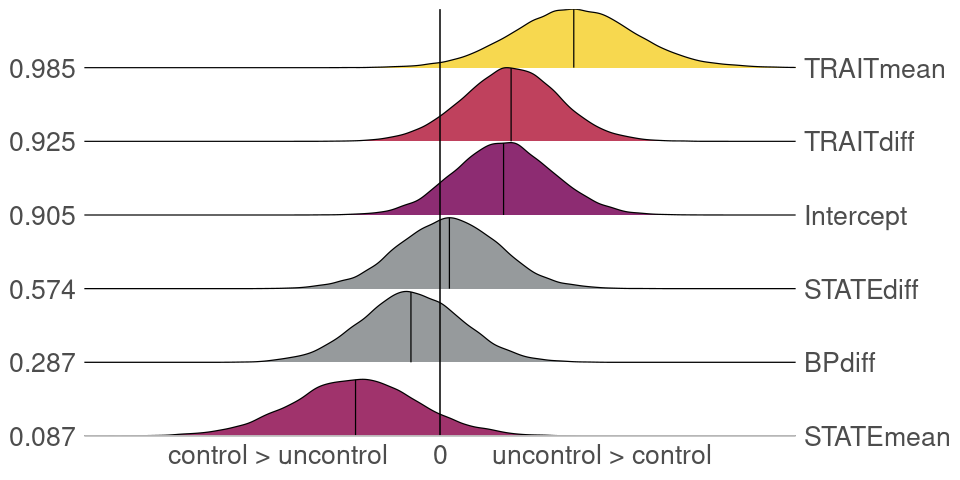

In [12]:
plotPDP(lBST)

### Left BST: Probability-Probability Plot

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


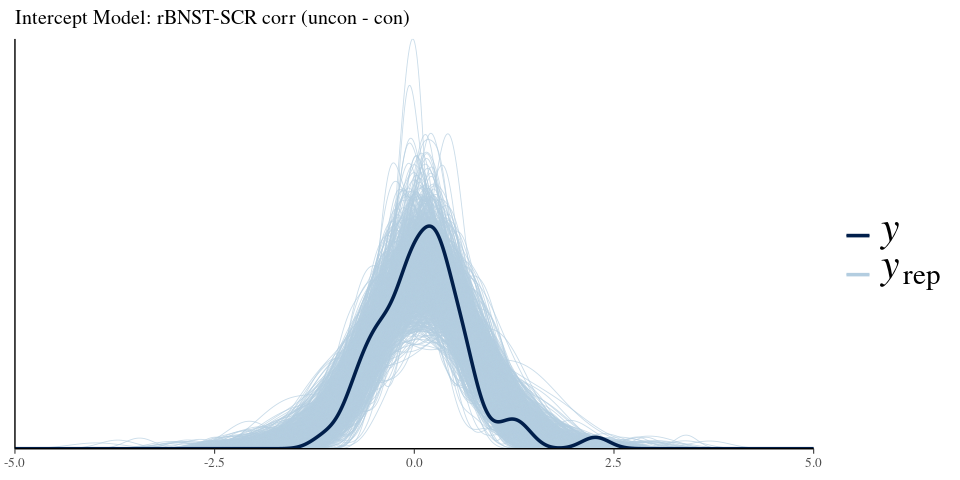

In [13]:
pp_plot = pp_check(lBST,nsamples = 1000)

pp_plot + xlim(-5,5) + theme(text = element_text(size=10),legend.text=element_text(size=25)) + ggtitle("Intercept Model: rBNST-SCR corr (uncon - con)",)

### **Right BST**

In [14]:
dataTable <- filter(df,ROI=='R BST')
head(dataTable)

,Pair,ROI,Y,uncontrol,control,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,R BST,-0.3144,0.1623,0.4767,-0.98840,-0.05585,-1.21328,-0.14419,-0.83706
2,P01,R BST,0.3881,0.2196,-0.1685,-0.40759,3.12760,-0.41928,0.49624,0.36577
3,P02,R BST,-0.7188,0.1292,0.8480,0.23776,0.29787,-0.49868,0.38950,-0.29032
4,P03,R BST,-0.2258,0.4389,0.6648,-1.56922,1.00530,-1.61027,-0.03745,0.32932
5,P04,R BST,0.7699,0.6407,-0.1292,-0.21398,-0.05585,-0.26049,0.70972,-0.76416
6,P05,R BST,-0.3117,0.1351,0.4468,0.30229,-0.05585,0.37471,-0.57115,-0.18097


In [15]:
rBST <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '8de379eb94c1c65b4bb71af1161758f1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.63 seconds (Warm-up)
Chain 1:                1.6 seconds (Sampling)
Chain

### Right BST: Summary

In [16]:
summary(rBST)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff + BPdiff 
   Data: dataTable (Number of observations: 57) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.11      0.06    -0.01     0.23 1.00    20061    14111
TRAITmean     0.07      0.08    -0.08     0.23 1.00    14307    14304
TRAITdiff     0.05      0.06    -0.07     0.18 1.00    18799    14680
STATEmean    -0.12      0.08    -0.28     0.04 1.00    13732    13592
STATEdiff     0.09      0.06    -0.04     0.22 1.00    19180    14279
BPdiff       -0.06      0.06    -0.19     0.06 1.00    17647    14503

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.44      0.05     0.36     0.55 1.00    15174    13539
nu       35.

### Right BST: Posteriors

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0084



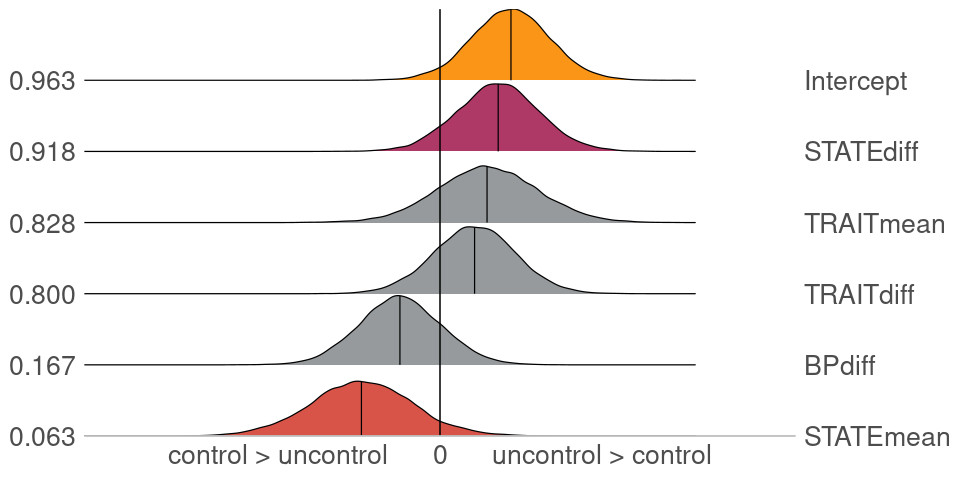

In [17]:
plotPDP(rBST)

### Right BST: Probability-Probability Plot

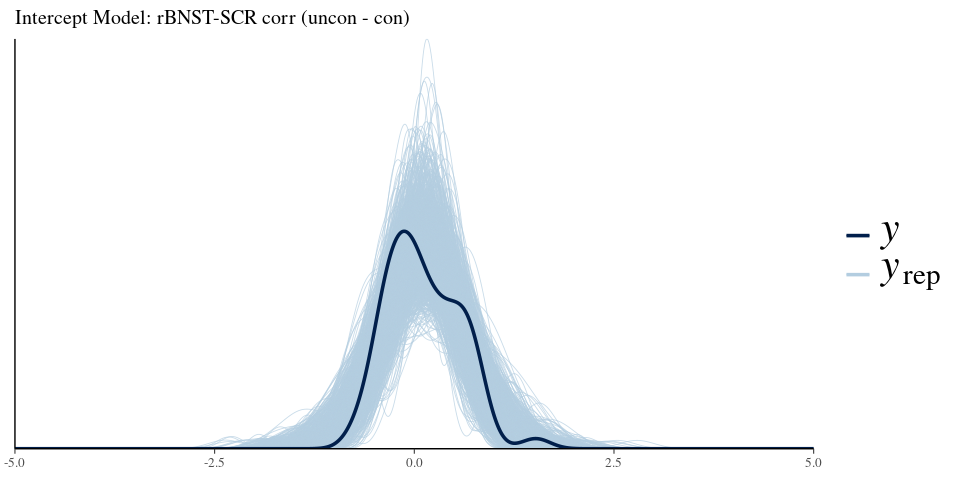

In [18]:
pp_plot = pp_check(rBST,nsamples = 1000)

pp_plot + xlim(-5,5) + theme(text = element_text(size=10),legend.text=element_text(size=25)) + ggtitle("Intercept Model: rBNST-SCR corr (uncon - con)",)

### **Left Dorsal Anterior Insula**

In [19]:
dataTable <- filter(df,ROI=='L Anterior dorsal insula')
head(dataTable)

,Pair,ROI,Y,uncontrol,control,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,L Anterior dorsal insula,-0.8973,0.0663,0.9636,-0.98840,-0.05585,-1.21328,-0.14419,-0.83706
2,P01,L Anterior dorsal insula,0.2306,0.3061,0.0755,-0.40759,3.12760,-0.41928,0.49624,0.36577
3,P02,L Anterior dorsal insula,-0.6166,0.2140,0.8305,0.23776,0.29787,-0.49868,0.38950,-0.29032
4,P03,L Anterior dorsal insula,0.0270,0.8898,0.8628,-1.56922,1.00530,-1.61027,-0.03745,0.32932
5,P04,L Anterior dorsal insula,0.0756,0.7700,0.6943,-0.21398,-0.05585,-0.26049,0.70972,-0.76416
6,P05,L Anterior dorsal insula,0.1882,1.0958,0.9076,0.30229,-0.05585,0.37471,-0.57115,-0.18097


In [20]:
ldAI <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '8de379eb94c1c65b4bb71af1161758f1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.67 seconds (Warm-up)
Chain 1:                2.59 seconds (Sampling)
Chai

### Left Dorsal Anterior Insula: Summary

In [21]:
summary(ldAI)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff + BPdiff 
   Data: dataTable (Number of observations: 57) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.04      0.08    -0.11     0.19 1.00    19554    12629
TRAITmean     0.03      0.10    -0.17     0.22 1.00    15148    14746
TRAITdiff     0.04      0.08    -0.12     0.20 1.00    18314    14719
STATEmean    -0.08      0.10    -0.28     0.12 1.00    15016    14262
STATEdiff     0.06      0.08    -0.09     0.22 1.00    18177    14209
BPdiff       -0.01      0.08    -0.17     0.15 1.00    17687    14186

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.56      0.07     0.44     0.69 1.00    14300    11282
nu       30.

### Left Dorsal Anterior Insula: Posteriors

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0106



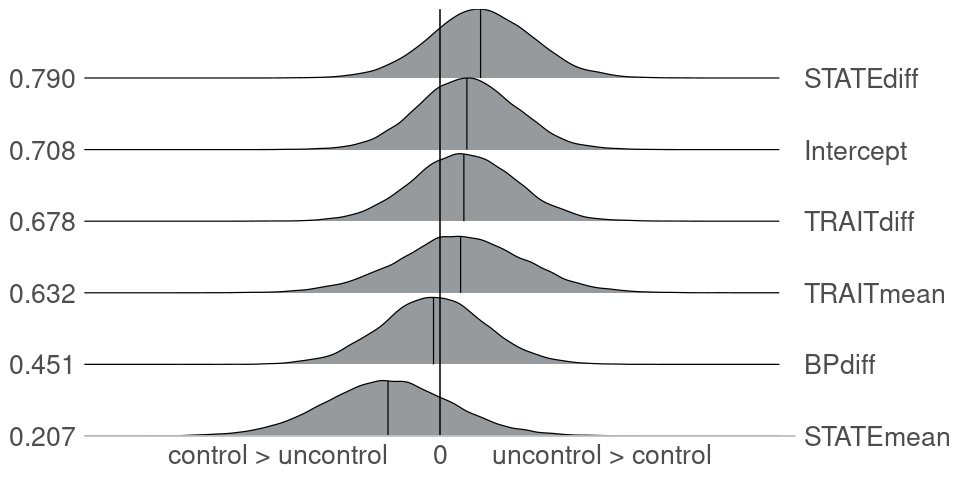

In [22]:
plotPDP(ldAI)

### Right BST: Probability-Probability Plot

Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


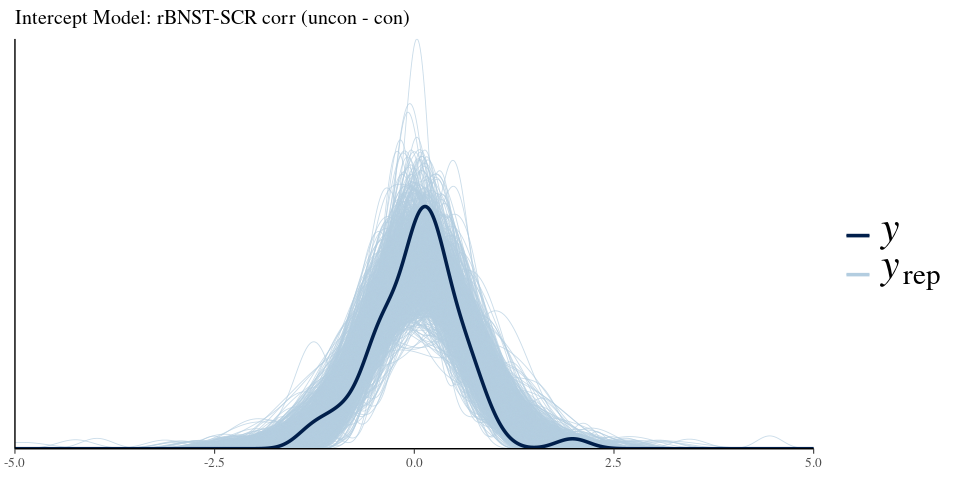

In [23]:
pp_plot = pp_check(ldAI,nsamples = 1000)

pp_plot + xlim(-5,5) + theme(text = element_text(size=10),legend.text=element_text(size=25)) + ggtitle("Intercept Model: rBNST-SCR corr (uncon - con)",)

In [24]:
rBST

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + TRAITmean + TRAITdiff + STATEmean + STATEdiff + BPdiff 
   Data: dataTable (Number of observations: 57) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.11      0.06    -0.01     0.23 1.00    20061    14111
TRAITmean     0.07      0.08    -0.08     0.23 1.00    14307    14304
TRAITdiff     0.05      0.06    -0.07     0.18 1.00    18799    14680
STATEmean    -0.12      0.08    -0.28     0.04 1.00    13732    13592
STATEdiff     0.09      0.06    -0.04     0.22 1.00    19180    14279
BPdiff       -0.06      0.06    -0.19     0.06 1.00    17647    14503

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.44      0.05     0.36     0.55 1.00    15174    13539
nu       35.

### Exporting posteriors

In [28]:
getPosteriors <- function(model){
    data <- fixef(model,summary = FALSE)
}

In [41]:
write.csv(getPosteriors(lBST),'../finalResults/brain-SCR_corr/posteriors/uncon_v_con_lBST_SCR_corr.txt')
write.csv(getPosteriors(rBST),'../finalResults/brain-SCR_corr/posteriors/uncon_v_con_rBST_SCR_corr.txt')
write.csv(getPosteriors(ldAI),'../finalResults/brain-SCR_corr/posteriors/uncon_v_con_ldAI_SCR_corr.txt')